# Build the response matrix from prep30

In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import pickle

In [2]:
# Select the file and the tree from which to generate the response matrix
files = "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/prep30/*.root"
workers = 45
step_size = "500 MB"

# Amount of bins and histogram limits
nbins, rmin, rmax = 50, 0.2, 1.8

In [3]:
# histograms to show the variables
invM      = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
matchedMC = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
# response matrix
R = bh.Histogram(
    bh.axis.Regular(nbins, rmin, rmax), bh.axis.Regular(nbins, rmin, rmax)
)

In [4]:
# variables to build the response matrix
leaves_to_use = ["tau_sig_matchedMC_InvM", "tau_sig_InvM", "nPi0s_sig"]
# variables to clean the data
leaves_to_use += ["track_sig_charge", "tauPlusMCMode", "tauMinusMCMode"]

for df in uproot.iterate(f"{files}:tau1x1", filter_name=leaves_to_use, step_size=step_size, num_workers=workers):
    # filter events with one pi0
    one_pi0 = df[ (df.nPi0s_sig == 1) ]
    # filter events that are signal
    signal = one_pi0[( 
        ( (one_pi0.track_sig_charge==1)  & (one_pi0.tauPlusMCMode ==4) ) | 
        ( (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode==4) )
    )]
    # build histograms
    invM.fill(signal.tau_sig_InvM)
    matchedMC.fill(signal.tau_sig_matchedMC_InvM)
    # build response matrix (2D histogram)
    R.fill(signal.tau_sig_InvM, signal.tau_sig_matchedMC_InvM)

# save histograms
import pickle

with open("tau2pipi0nu_response_matrix.pkl", "wb") as f:
    container = {
        "truth" : matchedMC,
        "reco"  : invM,
        "R"     : R,
    }
    pickle.dump(container, f)

## Plot

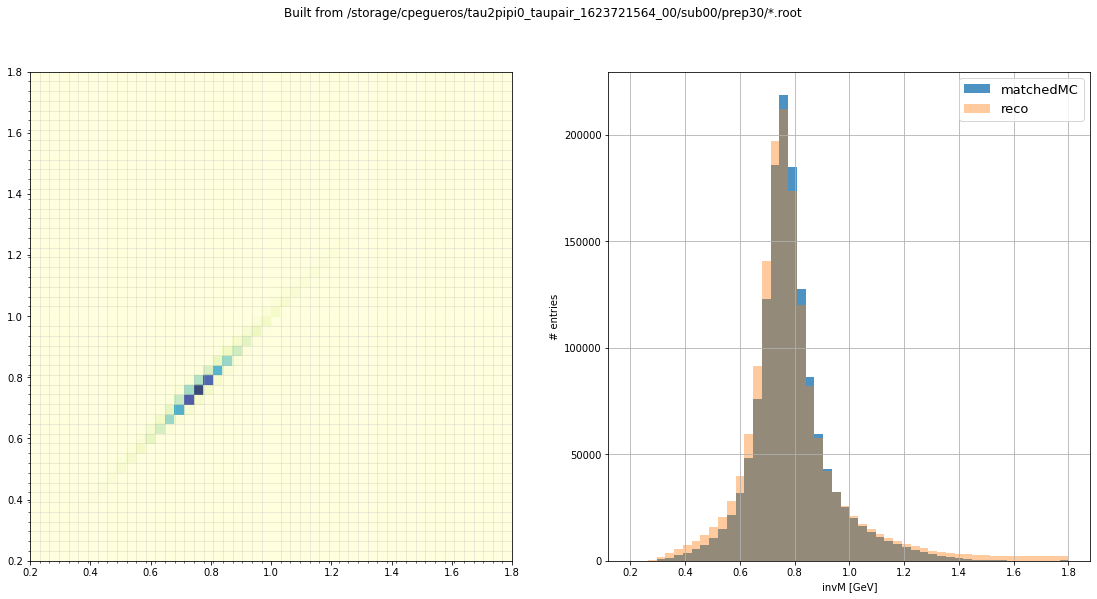

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(19, 9))
fig.suptitle(f"Built from {files}")

# Plot the response matrix
axs[0].pcolormesh(*R.axes.edges.T, R.view().T, cmap="YlGnBu", alpha=0.8)
axs[0].set_xticks(R.axes.edges[0], minor=True)
axs[0].set_yticks(R.axes.edges[0], minor=True)
axs[0].xaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
axs[0].yaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
axs[0].grid(which="minor", alpha=0.3)

# Plot the histograms
axs[1].bar(matchedMC.axes[0].centers, matchedMC.view(), width=matchedMC.axes[0].widths, label="matchedMC", alpha=0.8)
axs[1].bar(invM.axes[0].centers, invM.view(), width=invM.axes[0].widths, label="reco", alpha=0.4)
axs[1].grid()
axs[1].set_xlabel("invM [GeV]")
axs[1].set_ylabel("# entries")
axs[1].legend(prop={"size": 13})